In [1]:
import cv2 as cv
from frame_splitter import frameSplitter
import scipy
from scipy.signal import filtfilt, butter
import numpy as np
import os
import re
import shutil
from tqdm import tqdm
from pystackreg import StackReg
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
  

In [18]:
def calculate_window(fps, nseconds=2):
    window = fps*nseconds
    return window

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

def gaussian_filter(data,fps):
    sigma = calculate_window(fps,nseconds=2)
    return scipy.ndimage.filters.gaussian_filter(data, sigma,axes=0)

def no_filter(data,fps):
    return data

def stabilize_frames( raw_centres, fps):
    raw_centres_arr = np.array(raw_centres)
    
    # Gaussian filter
    smoothed_centres_gaussian =gaussian_filter(raw_centres_arr.squeeze(), fps)
    
    # StackReg stabilization
    sr = StackReg(StackReg.TRANSLATION)
    stabilized_centres = np.zeros_like(smoothed_centres_gaussian)
    for i in range(smoothed_centres_gaussian.shape[0]):
        transformed = sr.register_stack(smoothed_centres_gaussian[i, :, :].squeeze(), reference=smoothed_centres_gaussian[0, :, :].squeeze())
        stabilized_centres[i, :, :] = transformed

    return stabilized_centres



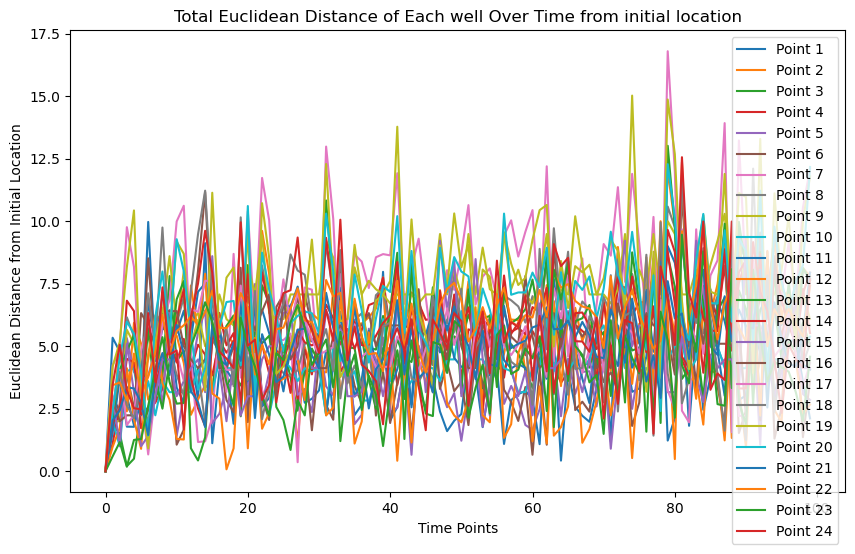

In [20]:
with open('raw_centres.npy', 'rb') as f:
    raw_signal = np.load(f)
    

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over the second dimension (24 points)
for j in range(raw_signal.shape[1]):
    # Extract x and y coordinates for each point
    x_values = np.arange(100)  # Assuming 100 time points
    x_coordinates = raw_signal[:, j, 0]  # X coordinates for the j-th point
    y_coordinates = raw_signal[:, j, 1]  # Y coordinates for the j-th point

    # Calculate the Euclidean distance from the initial location
    initial_location = np.array([x_coordinates[0], y_coordinates[0]])
    euclidean_distances = np.sqrt((x_coordinates - initial_location[0])**2 + (y_coordinates - initial_location[1])**2)

    # Plot the total Euclidean distance for each point
    plt.plot(x_values, euclidean_distances, label=f'Point {j + 1}')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Euclidean Distance from Initial Location')
plt.title('Total Euclidean Distance of Each well Over Time from initial location')
plt.legend()  # Add legend for different points

# Show the plot
plt.show()


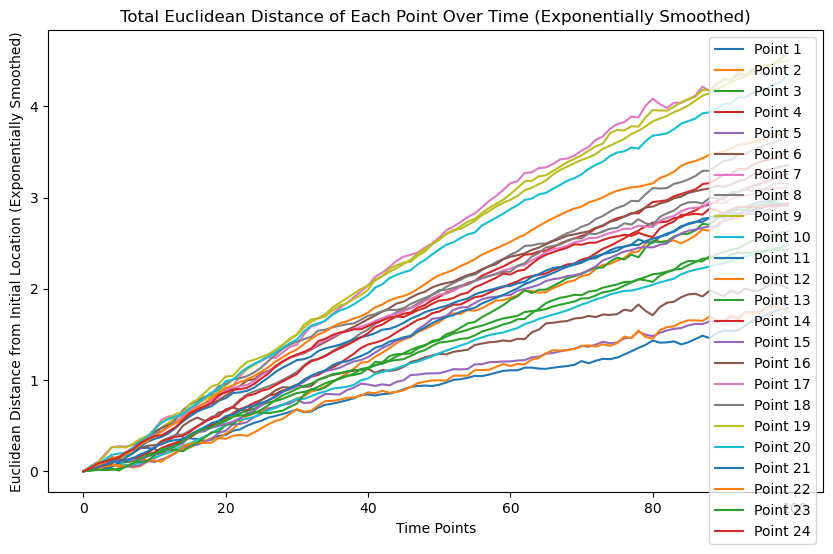

In [24]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Smoothing factor (alpha)
alpha = 0.01 # You can adjust this value based on your preference

# Iterate over the second dimension (24 points)
for j in range(raw_signal.shape[1]):
    # Extract x and y coordinates for each point
    x_coordinates = raw_signal[:, j, 0]  # X coordinates for the j-th point
    y_coordinates = raw_signal[:, j, 1]  # Y coordinates for the j-th point

    # Apply exponential smoothing
    smoothed_x = [x_coordinates[0]]  # Initialize with the first value
    smoothed_y = [y_coordinates[0]]
    for i in range(1, len(x_coordinates)):
        smoothed_x.append(alpha * x_coordinates[i] + (1 - alpha) * smoothed_x[-1])
        smoothed_y.append(alpha * y_coordinates[i] + (1 - alpha) * smoothed_y[-1])

    # Calculate the Euclidean distance from the initial location using smoothed coordinates
    initial_location = np.array([smoothed_x[0], smoothed_y[0]])
    euclidean_distances = np.sqrt((np.array(smoothed_x) - initial_location[0])**2 + (np.array(smoothed_y) - initial_location[1])**2)

    # Plot the total Euclidean distance for each point
    plt.plot(np.arange(len(x_coordinates)), euclidean_distances, label=f'Point {j + 1}')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Euclidean Distance from Initial Location (Exponentially Smoothed)')
plt.title('Total Euclidean Distance of Each Point Over Time (Exponentially Smoothed)')
plt.legend()  # Add legend for different points

# Show the plot
plt.show()

C:\Users\Lindsay\AppData\Local\Temp\ipykernel_18012\723532908.py:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return scipy.ndimage.filters.gaussian_filter(data, sigma,axes=0)


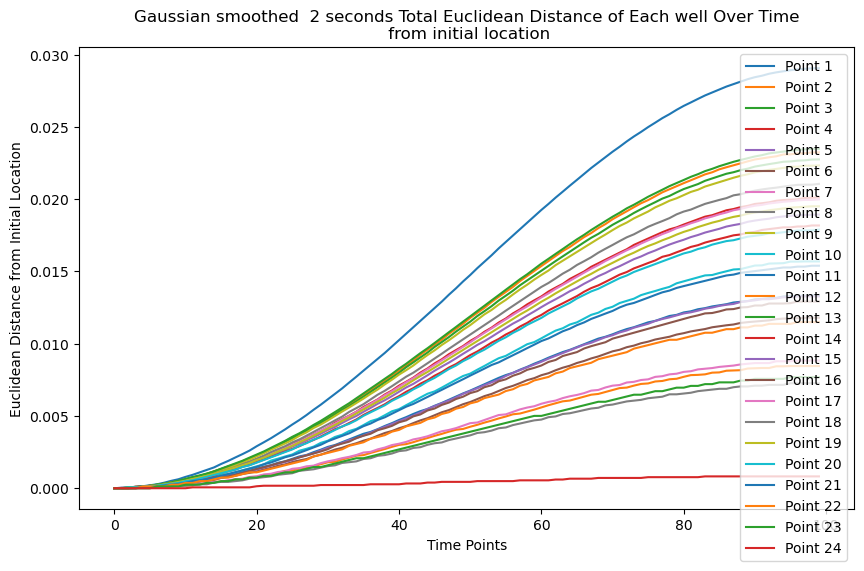

In [19]:
with open('raw_centres.npy', 'rb') as f:
    raw_signal = np.load(f)
    
gaussian_signal=gaussian_filter(raw_signal,50)
# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over the second dimension (24 points)
for j in range(gaussian_signal.shape[1]):
    # Extract x and y coordinates for each point
    x_values = np.arange(100)  # Assuming 100 time points
    x_coordinates = gaussian_signal[:, j, 0]  # X coordinates for the j-th point
    y_coordinates = gaussian_signal[:, j, 1]  # Y coordinates for the j-th point

    # Calculate the Euclidean distance from the initial location
    initial_location = np.array([x_coordinates[0], y_coordinates[0]])
    euclidean_distances = np.sqrt((x_coordinates - initial_location[0])**2 + (y_coordinates - initial_location[1])**2)

    # Plot the total Euclidean distance for each point
    plt.plot(x_values, euclidean_distances, label=f'Point {j + 1}')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Euclidean Distance from Initial Location')
plt.title('Gaussian smoothed  2 seconds Total Euclidean Distance of Each well Over Time\n from initial location')
plt.legend()  # Add legend for different points

# Show the plot
plt.show()


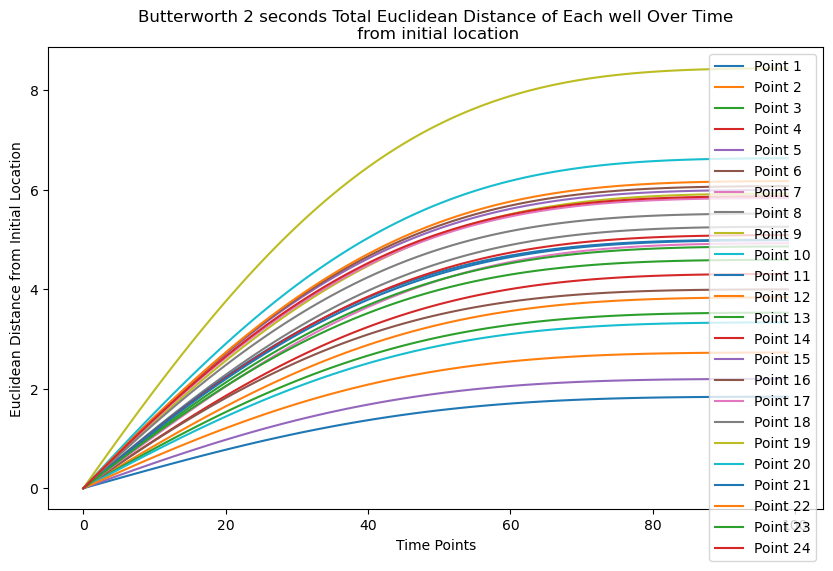

In [36]:
with open('raw_centres.npy', 'rb') as f:
    raw_signal = np.load(f)
fps=50
butter_signal=butter_lowpass_filter(raw_signal, cutoff=0.3, fs=fps, order=4)
# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over the second dimension (24 points)
for j in range(butter_signal.shape[1]):
    # Extract x and y coordinates for each point
    x_values = np.arange(100)  # Assuming 100 time points
    x_coordinates = butter_signal[:, j, 0]  # X coordinates for the j-th point
    y_coordinates = butter_signal[:, j, 1]  # Y coordinates for the j-th point

    # Calculate the Euclidean distance from the initial location
    initial_location = np.array([x_coordinates[0], y_coordinates[0]])
    euclidean_distances = np.sqrt((x_coordinates - initial_location[0])**2 + (y_coordinates - initial_location[1])**2)

    # Plot the total Euclidean distance for each point
    plt.plot(x_values, euclidean_distances, label=f'Point {j + 1}')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Euclidean Distance from Initial Location')
plt.title('Butterworth 2 seconds Total Euclidean Distance of Each well Over Time\n from initial location')
plt.legend()  # Add legend for different points

# Show the plot
plt.show()


In [57]:
import numpy as np




def filter_coordinates(coordinates, threshold=50):
    n, _, _ = coordinates.shape

    # Initialize the filtered coordinates array
    filtered_coordinates = np.zeros_like(coordinates)

    # Iterate over time points
    for t in range(n):
        if  t==0:
            filtered_coordinates[t, :, 0] = coordinates[t , :, 0]
            filtered_coordinates[t, :, 1] = coordinates[t , :, 1]
            continue
        # Calculate the median change in x and y
        median_change_x = np.median(np.median(coordinates[t, :, 0] - coordinates[t - 1, :, 0]))
        median_change_y = np.median(np.median(coordinates[t, :, 1] - coordinates[t - 1, :, 1]))
        print(median_change_x, "\n")
        # Check if the median change exceeds the threshold
        if abs(median_change_x) > threshold:
            # Update x coordinates based on the median change
            filtered_coordinates[t, :, 0] = filtered_coordinates[t-1, :, 0] + median_change_x
        else:
            # Keep x coordinates the same as the previous time point
            filtered_coordinates[t, :, 0] = coordinates[t - 1, :, 0]

        if abs(median_change_y) > threshold:
            # Update y coordinates based on the median change
            filtered_coordinates[t, :, 1] = filtered_coordinates[t-1, :, 1] + median_change_y
        else:
            # Keep y coordinates the same as the previous time point
            filtered_coordinates[t, :, 1] = coordinates[t - 1, :, 1]

    return filtered_coordinates

(100, 24, 2)


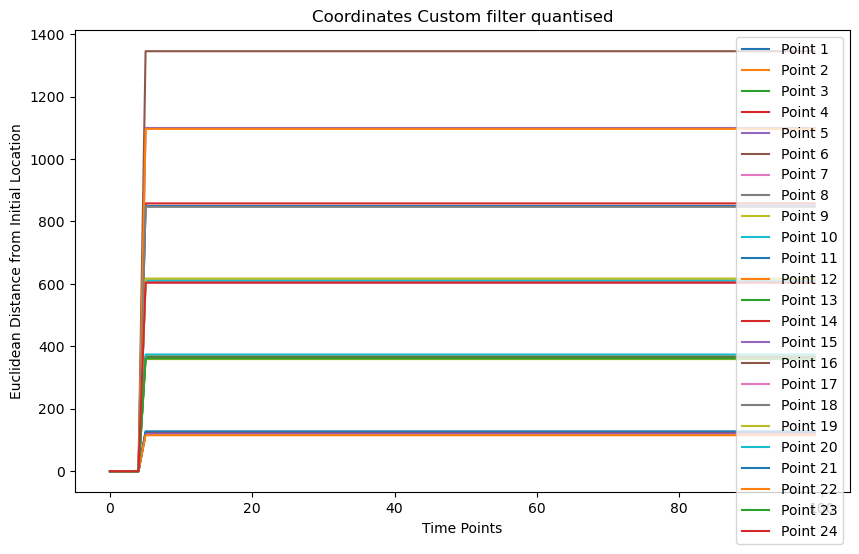

In [78]:
with open('raw_centres.npy', 'rb') as f:
    raw_signal = np.load(f)

coords_filtered = filter_coordinates(raw_signal)

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over the second dimension (24 points)
for j in range(coords_filtered.shape[1]):
    # Extract x and y coordinates for each point
    x_values = np.arange(100)  # Assuming 100 time points
    x_coordinates = coords_filtered[:, j, 0]  # X coordinates for the j-th point
    y_coordinates = coords_filtered[:, j, 1]  # Y coordinates for the j-th point

    # Calculate the Euclidean distance from the initial location
    initial_location = np.array([x_coordinates[0], y_coordinates[0]])
    euclidean_distances = np.sqrt((x_coordinates - initial_location[0])**2 + (y_coordinates - initial_location[1])**2)

    # Plot the total Euclidean distance for each point
    plt.plot(x_values, euclidean_distances, label=f'Point {j + 1}')

# Add labels and title
plt.xlabel('Time Points')
plt.ylabel('Euclidean Distance from Initial Location')
plt.title('Coordinates Custom filter quantised')
plt.legend()  # Add legend for different points

# Show the plot
plt.show()

In [77]:
def filter_coordinates(coordinates, threshold=3):
    n, _, _ = coordinates.shape

    # Initialize the filtered coordinates array
    filtered_coordinates = np.zeros_like(coordinates)

    # Iterate over time points
    for t in range(n):
        if  t==0:
            filtered_coordinates[t, :, 0] = coordinates[t , :, 0]
            filtered_coordinates[t, :, 1] = coordinates[t , :, 1]
            continue
        # Calculate the median change in x and y
        median_change_x = np.median(coordinates[t, :, 0] - coordinates[t - 1, :, 0])
        median_change_y = np.median(coordinates[t, :, 1] - coordinates[t - 1, :, 1])
        #print(f"Time {t}: Median Change (x, y) = ({median_change_x}, {median_change_y})")
        # Check if the median change exceeds the threshold
        if abs(median_change_x) > threshold:
            # Update x coordinates based on the median change
            filtered_coordinates[t, :, 0] = filtered_coordinates[t - 1, :, 0] + median_change_x
        else:
            # Keep x coordinates the same as the previous time point
            filtered_coordinates[t, :, 0] = filtered_coordinates[t - 1, :, 0]

        if abs(median_change_y) > threshold:
            # Update y coordinates based on the median change
            filtered_coordinates[t, :, 1] = filtered_coordinates[t - 1, :, 0]+ median_change_y
        else:
            # Keep y coordinates the same as the previous time point
            filtered_coordinates[t, :, 1] = filtered_coordinates[t - 1, :, 1]
    print(filtered_coordinates.shape)
    return filtered_coordinates
